# Cutting Trajectories

In [1]:
import os
os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())

working dir /home/tales/dev/master/mdc_analysis


In [19]:
import pandas as pd
import numpy as np
import math
import copy

from bokeh.models import PrintfTickFormatter
from bokeh.io import output_notebook, show

from src.dao import csv_dao, objects_dao
from src.plot.basic_plot import plot_result
from src.similarity.extreme_travelers import sequence_report
from src.data_processment.input_data_version2 import InputDataManager
from src.utils.time_utils import human_time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
output_notebook()

Loading BokehJS ...

## Loading User Data

In [5]:
# users_srg = objects_dao.load_all_stop_region_group_object()
# users_tags = objects_dao.load_users_tags_sequence(sr_stay_time_above_h=0.5)["orignal"]

In [6]:
users_gps_dir = os.listdir("outputs/user_gps/")
users_gps = {}

for user_gps_dir in users_gps_dir:
    user = user_gps_dir.split("_")[0]
    users_gps[user] = csv_dao.load_user_gps_csv(user)

## Gaps

How many gaps above 06h ? <br> 
How many gaps above 12h ? <br> 
How many gaps above 24h ? <br>
How many gaps above 48h ? <br>
How much time the user has participated?

In [7]:
def gap_missing_values(report):
    t2 = report.iloc[1:len(report)]["local_time"].astype(float).reset_index(drop=True)
    t1 = report.iloc[0:len(report) - 1]["local_time"].astype(float).reset_index(drop=True)
    gaps = t2 - t1
    gaps.index = report.iloc[1:len(report)]["local_time"]
    head = pd.Series([None], index=[t1.iloc[0].item()])
    return head.append(gaps)

def gap_amount(gap, min_time_h):
    present_data_sum = gap[gap <= 60 * 60 * min_time_h].sum()
    missing_data_sum = gap[gap > 60 * 60 * min_time_h].sum()
    
    return {"missing_data_sum": missing_data_sum, "present_data_sum": present_data_sum}

def user_time_participation(report):
    first = report["local_time"].min()
    last = report["local_time"].max()
    
    n_days = (last - first) / (60*60*24)
    
    return {"n_days": n_days,
            "n_years": n_days / 365.25,
            "datetime_start": human_time(first, datetime_format='%d-%m-%Y %H:%M:%S')["datetime"],
            "datetime_end": human_time(last, datetime_format='%d-%m-%Y %H:%M:%S')["datetime"]}
    
def gaps_summary(gaps, min_time_h):
    selection = gaps[gaps > 60 * 60 * min_time_h]
    return {"n_gaps": len(selection),
            "median_sec": selection.median(),
            "min_time_gap": min_time_h}

def merge_dicts(dicts):
    final_dict = {}
    
    for d in dicts:
        
        for k in d.keys():
            final_dict[k] = d[k]

    return final_dict

def gaps_week(gaps, user_data, min_time_h):    
    gaps_df = pd.DataFrame({"gaps": gaps.tolist(), "local_time": user_data["local_time"][0:-1].tolist()})
    gaps_df["week"] = ((gaps_df["local_time"] - gaps_df["local_time"].min()) / (60*60*24*7)).apply(math.floor)
    
    return gaps_df[gaps_df["gaps"] > 60*60*min_time_h]

In [8]:
users_gaps_summary = []

for user_id in users_gps.keys():
    user_gps = users_gps[user_id]
   
    if len(user_gps) == 0:
        continue

    gaps = gap_missing_values(user_gps)
    
    user_data = {"user_id": user_id}
    user_time = user_time_participation(user_gps)
    
    for hour in [6, 12, 18, 24, 30, 36, 42, 48]:
        user_gaps_report = gaps_summary(gaps, hour)
        gap_time_sum = gap_amount(gaps, hour)
        
        users_gaps_summary.append(merge_dicts([user_data, user_time, user_gaps_report, gap_time_sum]))

users_gaps_summary = pd.DataFrame(users_gaps_summary)[["user_id", "min_time_gap", "n_gaps", "median_sec", "missing_data_sum", "present_data_sum", "datetime_end", "datetime_start", "n_years", "n_days"]]

### Counting number of gaps 
Gaps grater than 6, 12, 18, 24, 30, 36, 42 and 48 hours

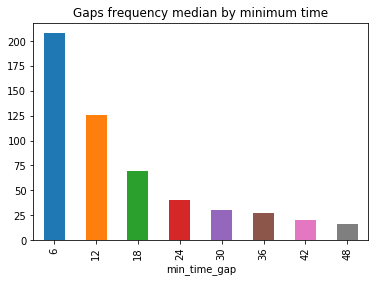

In [9]:
users_gaps_summary.groupby("min_time_gap")["n_gaps"].median().plot.bar(title="Gaps frequency median by minimum time")

### Counting frequency of gaps per day 
Gaps grater than 6, 12, 18, 24, 30, 36, 42 and 48 hours

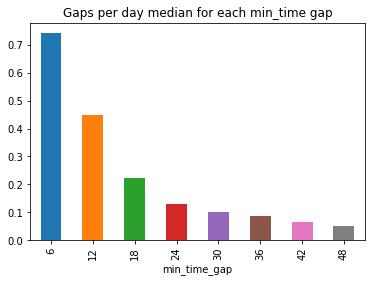

In [10]:
users_gaps_summary["gaps_per_day"] = users_gaps_summary["n_gaps"] / users_gaps_summary["n_days"]
users_gaps_summary.groupby("min_time_gap")["gaps_per_day"].median().plot.bar(title="Gaps per day median for each min_time gap")

### What is the proportion of total gaps times 
Gaps grater than 6, 12, 18, 24, 30, 36, 42 and 48 hours

In [11]:
users_gaps_summary["valid_amount_h"] = users_gaps_summary["missing_data_sum"] / (users_gaps_summary["missing_data_sum"] + users_gaps_summary["present_data_sum"])
users_gaps_summary["valid_amount_h"] = users_gaps_summary["valid_amount_h"].astype(float)

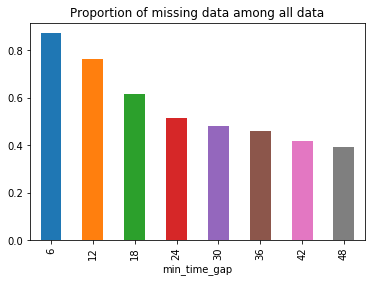

In [12]:
users_gaps_summary.groupby("min_time_gap")["valid_amount_h"].median().plot.bar(title="Proportion of missing data among all data")

# Cutting Trajectories

In [14]:
# user_tags_sequence = objects_dao.load_users_tags_sequence()

In [15]:
def cut_traj_in_trips(user_gps_data, gap_tresh_minutes):
    start_stop_gaps = []
    
    gaps_data = gap_missing_values(user_gps_data).to_frame().reset_index().rename({0: "gap_time", "index": "stop"}, axis=1)
    
    gaps_data["start"] = [None] + gaps_data.iloc[0 : len(gaps_data) - 1]["stop"].tolist()
    gaps_data["start"] = gaps_data["start"].replace({np.NaN: None})
    
    selected_gaps = gaps_data[gaps_data["gap_time"] > gap_tresh_minutes * 60]
    
    return selected_gaps[["gap_time", "start", "stop"]]
    
gaps_times = cut_traj_in_trips(users_gps["5937"], 30)
gaps_times.head(6)

,gap_time,start,stop
245,15651.00,1253639643.00,1253655294.00
253,26816.00,1253655703.00,1253682519.00
329,865123.00,1253683561.00,1254548684.00
844,4801.00,1254557227.00,1254562028.00
1897,56784.00,1254580460.00,1254637244.00
1976,8506.00,1254638336.00,1254646842.00


# Applying Trajectories Cut To InputDataManager

In [16]:
# srs = objects_dao.load_all_stop_region_group_object()

In [17]:
# tags = objects_dao.load_users_tags_sequence()

In [18]:
# srs["5954"].sequence_report(enrich_columns=True)[["start_time", "end_time", "stay_time_h"]]

In [ ]:
# tags["original"]["5954"]

In [20]:
data_manager = InputDataManager()

In [ ]:
input_data = {}

for version in data_manager.avaliable_versions():
    for sr_min_time in [5,10,15,20,25,30]:
        input_data[version] = {sr_min_time: data_manager.get_input_data(version=version, sr_stay_time=sr_min_time)}
        
        